# GEONE - Variogram analysis and kriging for data in 1D

Interpolate a data set in 1D, using simple or ordinary kriging. Starting from a data set in 1D, the following is done:

- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

**Note:** most of the tools illustrated below can also be used for data in 2D or 3D assuming omni-directional covariance / variogram models.


## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Preparation - build a data set in 1D
A data set in 1D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [3]:
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('spherical', {'w':7., 'r':100}),   # elementary contribution
    ('exponential', {'w':2.9, 'r':50}), # elementary contribution
    ('nugget', {'w':0.1})               # elementary contribution
    ], name='ref model')

In [4]:
cov_model_ref

*** CovModel1D object ***
name = 'ref model'
number of elementary contribution(s): 3
elementary contribution 0
    type: spherical
    parameters:
        w = 7.0
        r = 100
elementary contribution 1
    type: exponential
    parameters:
        w = 2.9
        r = 50
elementary contribution 2
    type: nugget
    parameters:
        w = 0.1
*****

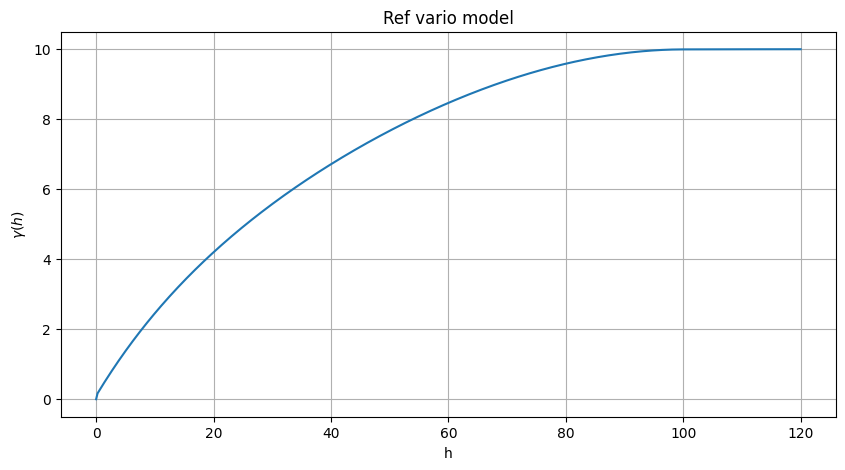

In [5]:
# Plot reference variogram model
plt.figure(figsize=(10,5))
cov_model_ref.plot_model(vario=True)
plt.title('Ref vario model')
plt.show()


Generate a gaussian random field in 1D (see function `geone.grf.grf1D`), and extract data points:

- `n`: number of data points
- `x`: location of data points (1-dimensional array of length `n`)
- `v`: values at data points (1-dimensional array of length `n`)

In [6]:
# Simulation grid (domain)
nx = 1000 # number of cells
sx = 0.5  # cell unit
ox = 0.0  # origin
# xmin, xmax = ox, ox + nx*sx # bounds of the simulation domain

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf1D(cov_model_ref, nx, sx, ox, nreal=1) # 2d-array of shape 1 x nx

im_ref = gn.img.Img(nx, 1, 1, sx, 1., 1., ox, 0., 0., nv=1, val=ref) # fill image (Img class from geone.img) 

# Extract n points from the reference simulation
n = 40
np.random.seed(987)
x = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin()) # random location in the grid
f = gn.img.Img_interp_func(im_ref, iy=0, iz=0) # function interpolating the image values
v_true = f(x) # value at x

# Add noise (Gaussian) to the values
v_err_std = 0.2
v = v_true + scipy.stats.norm.rvs(size=n, loc=0, scale=v_err_std)


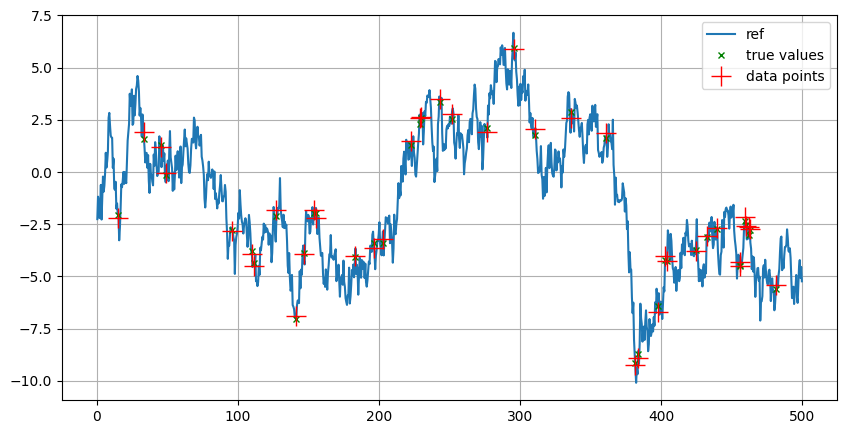

In [7]:
# Plot reference simulation and data points
plt.figure(figsize=(10,5))
plt.plot(im_ref.x(), ref[0], label='ref')
plt.plot(x, v_true, c='green', ls='', marker='x', markersize=5, label='true values')
plt.plot(x, v, c='red', ls='', marker='+', markersize=15, label='data points')
plt.grid()
plt.legend()
plt.show()

## Start from a data set in 1D

- `n`: number of data points
- `x`: 1-dimensional array of length `n`: locations of data points
- `v`: 1-dimensional array of length `n`: values at data points

Visualise the data set and the histogram of values.

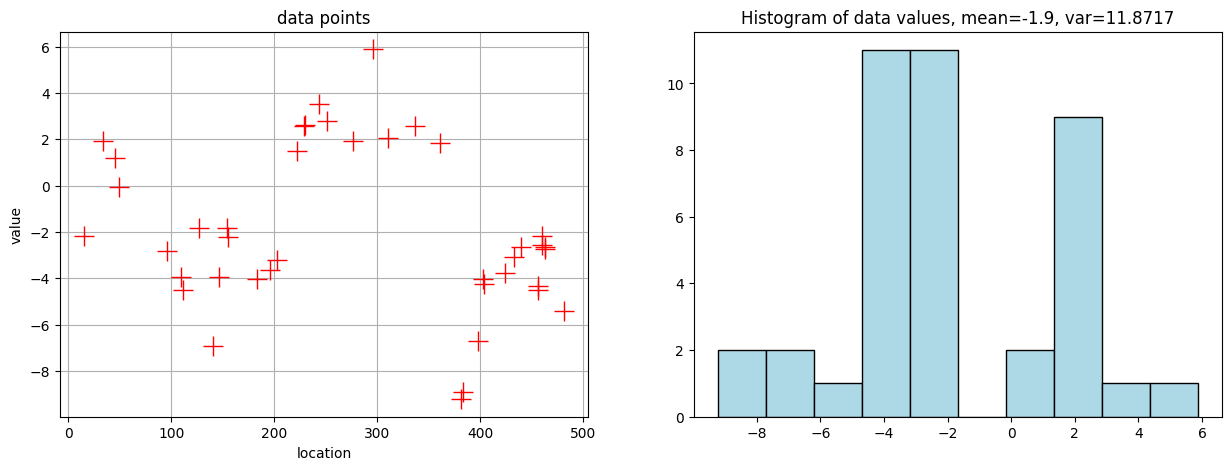

In [8]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x, v, 'r+', markersize=15)
plt.xlabel('location')
plt.ylabel('value')
plt.grid()
plt.title('data points')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram cloud
Compute the variogram cloud. The pair of the i-th and j-th data points gives the point $(h(i,j), g(i,j))$ in the variogram cloud, where

- $h(i,j) = \vert\vert x(i)-x(j)\vert\vert$ is the distance between $x(i)$ and $x(j)$ (lag)
- $g(i,j) = 1/2 \cdot (v(i)-v(j))^2)$ is the corresponding $\gamma$ value

The function `geone.covModel.variogramCloud1D` returns two 1-dimensional arrays `h` and `g` of same length `npair` containing the coordinates of the points in the variogram cloud. The maximal distance between two data points to be integrated in the variogram cloud can be specified by the keyword argument `hmax`. Note that a plot of the variogram cloud is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* variogram cloud.

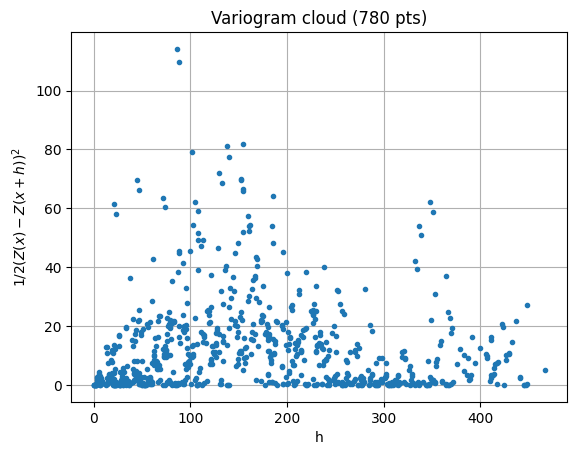

In [9]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)

### Experimental variogram
Compute the experimental variogram. It is obtained from the variogram cloud by computing the mean points of variogram cloud points within vertical bands (classes for the lags). A class for a lag is an interval along the $h$-axis. 

The function `geone.covModel.variogramExp1D` returns three 1-dimensional arrays `hexp`, `gexp`, and `cexp` of same length (number of classes), where `hexp` and `gexp` contain the coordinates of the mean points of each class and `cexp` the number (counter) of points in each class.

The variogram cloud (if already computed) can be passed directly to the function `geone.covModel.variogramExp1D` via the keyword argument `geone.covModel.variogramCloud`: in this case, the arguments `x`, `v`, (and optional `hmax`) are not used. The classes can be defined in several ways: specifying the number of classes (`ncla`) / specifying the class centers (`cla_center`) / specifying the class length(s) (`cla_length`) (in particular overlapping classes are possible), see doc of the function). Note that a plot of the experimental variogram is made by default (keyword argument `make_plot=True`) with the counters displayed (keyword argument `show_count=True`).

**Note:** for data in 2D or 3D, this function computes the *omni-directional* experimental variogram.

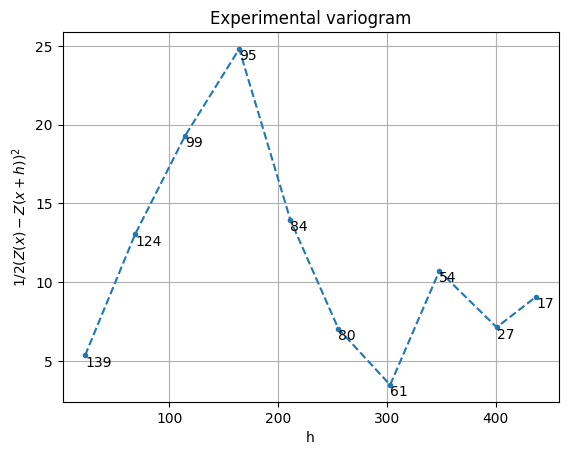

In [10]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 

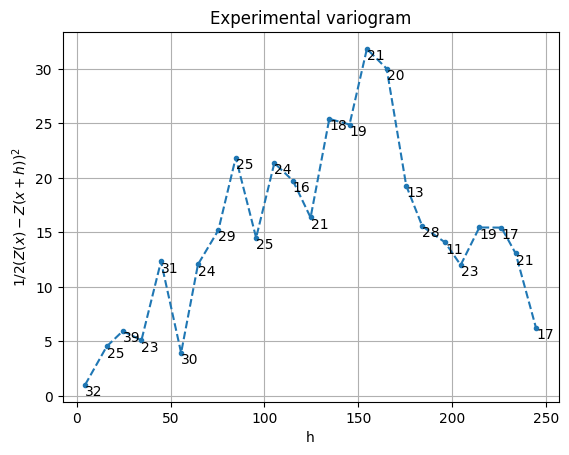

In [11]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, cla_center=np.arange(5, 250, 10))

Note that the function `geone.covModel.plot_variogramExp1D` allows to plot an experimental variogram (already computed): `geone.covModel.plot_variogramExp1D(hexp, gexp, cexp)` gives the plot above.

### Model fitting
The function `geone.covModelcovModel1D_fit` allows to fit a covariance / variogram model in 1D to given data.

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 1D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points (*i.e.* fit to the points of the variogram cloud). Hence, the fitting does not depend on the experimental variogram, *i.e.* on the choice of the classes for the lags.

The function `geone.covModelcovModel1D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

**Note:** for data in 2D or 3D, this function fits an *omni-directional* model.

In [12]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
    ], name='')
try:
    cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize)
    plt.show()
except Exception as exc:
    print('ERROR:', exc)

ERROR: covModel1D_fit: fitting covariance model failed


#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `geone.covModelcovModel1D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

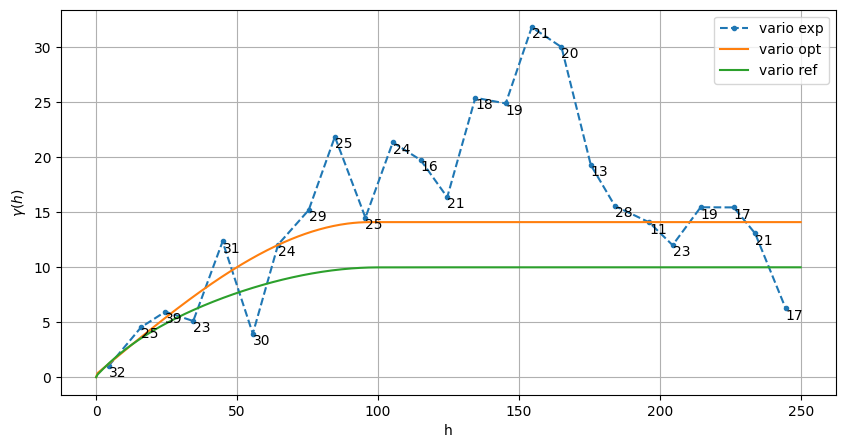

*** CovModel1D object ***
name = ''
number of elementary contribution(s): 4
elementary contribution 0
    type: gaussian
    parameters:
        w = 4.676321570099125e-08
        r = 80.7522710352472
elementary contribution 1
    type: spherical
    parameters:
        w = 13.843363090302038
        r = 97.1384629827674
elementary contribution 2
    type: exponential
    parameters:
        w = 2.9867267281186667e-13
        r = 74.79632981405173
elementary contribution 3
    type: nugget
    parameters:
        w = 0.26719882643054554
*****

In [13]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize,# hmax=300,
                                                 bounds=([ 0,   0,  0,   0,  0,   0,  0], 
                                                         [20, 300, 20, 300, 20, 300, 20]),
                                                 make_plot=False)
# bounds are given for:
#  index 0: parameter 'w' of gaussian contribution
#  index 1: parameter 'r' of gaussian contribution
#  index 2: parameter 'w' of spherical contribution
#  index 3: parameter 'r' of spherical contribution
#  index 4: parameter 'w' of exponential contribution
#  index 5: parameter 'r' of exponential contribution
#  index 6: parameter 'w' of nugget contribution

# Compare variogram exp. / variogram opt. / variogram ref
plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25, label='vario exp') # equiv.
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
cov_model_ref.plot_model(vario=True, hmax=250, label='vario ref')
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` performs a cross-validation test by leave-one-out (LOO) error. Given a data set, a covariance model and a kriging interpolator, the kriging estimate $Z^*(x)$ and standard deviation $\sigma^*(x)$ are computed at each data point $x$, based on the data set without that data point $(x, Z(x))$ and the given covariance model.

The interpolator (function) used is passed by the keyword argument `interpolator` of the function `geone.covModel.cross_valid_loo`; the keyword argument `interpolator_kwargs` is a dictionary containing the keyword arguments that are passed to the function `interpolator`. By default:

- `interpolator=geone.covModel.krige`, `interpolator_kwargs=None`: the function `geone.covModel.krige` is used as interpolator with default parameters, *i.e.* simple_kriging is used with mean value at the data points taken into account (*i.e* without the removed data point)

To use ordinary kriging as interpolator, set `interpolator_kwargs={'method':'ordinary_kriging'}` (see below details about the function `geone.covModel.krige`).

The continuous rank probability score (CRPS) is computed for each data point $x$ and defined as
$\operatorname{crps}(F, x) = -\int_{-\infty}^{+\infty} \left(F(y)-\mathcal{1}\{y\geqslant x\}\right)^2 dy$, where $F$ is the cumulative distribution function (CDF) of the prediction at $x$, i.e. in this case, $F$ is the CDF of a normal distribution of mean $Z^*(x)$ and variance ${\sigma^*}^2(x)$, $\mathcal{N}(Z^*(x), {\sigma^*}^2(x))$. A "default" CRPS, corresponding to the unbiased prediction (i.e. $Z^*(x)=Z(x)$) with a variance given by the variance of the data values, is also computed.

Two statisic tests are performed on the normalized error $errn(x) = (Z^*(x)-Z(x))/\sigma^*(x)$, which should approximately follows a standard normal distribution, $\mathcal{N}(0, 1)$. Let $n$ be the number of data points.

#### Normal law test for mean of normalized error
With $\operatorname{mean}(errn)=1/n\sum_i errn(x[i])$, the test computes:

- the p-value: $\mathbb{P}\left(\vert Z\vert \geqslant \vert\operatorname{mean}(errn)\vert\right)$, where $Z\sim\mathcal{N}(0, 1/n)$

#### Chi-square test for the sum of squares of normalized error
With $SSerrn = \sum_i errn(x[i])^2$,  the test computes:

- the p-value: $\mathbb{P}\left(X \geqslant SSern\right)$, where $X\sim\mathcal{\chi}^2_{n}$, the chi-square distribution with $n$ degrees of freedom

#### Interpretation
A low p-value (e.g. below a significance level $\alpha=5\%$) means that the model should be rejected (falsely rejected with probability $\alpha$): the smaller the p-value, the more evidence there is to reject the model. Each test computes the p-value and the result (success/failure): the boolean `success=(p-value > significance)`, which means that the model should be rejected when `success=False` with respect to the specified `significance` level.

#### Other statistics and plots
Specifying the keyword argument `print_result=True` (default), the function `geone.covModel.cross_valid_loo` prints the results of the statistics tests above, and some other statistics of the normalized error: the mean, standard deviation, skewness, excess kurtosis, to be compared with the standard normal distribution $\mathcal{N}(0,1)$.

Specifying the keyword argument `make_plot=True` (default), the function `geone.covModel.cross_valid_loo` displays some plots about the cross-validation. 

#### Returns
The function returns

- `cv_est`, `cv_std`: respectively the cross-validation estimates $Z^*(x)$ and standard deviation $\sigma^*(x)$ for every data point (sequence / array of length $n$)
- `crps`, `crps_def`: the CRPS for every data points (array `crps`), and the "default" CRPS (of the unbiased prediction with a variance given by the variance of the data values) (float `crps_def`)
- `pvalue`, `success`: respectively the p-values (floats) and the result (booleans) of each test (sequence of length $2$)


----- CRPS (negative; the larger, the better) -----
   mean = -0.8601
   def. = -0.8052
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9614
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.6511
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = 0.007651 (should be close to 0)
   std      = 0.9486 (should be close to 1)
   skewness = -0.2492 (should be close to 0)
   excess kurtosis = 0.8769 (should be close to 0)


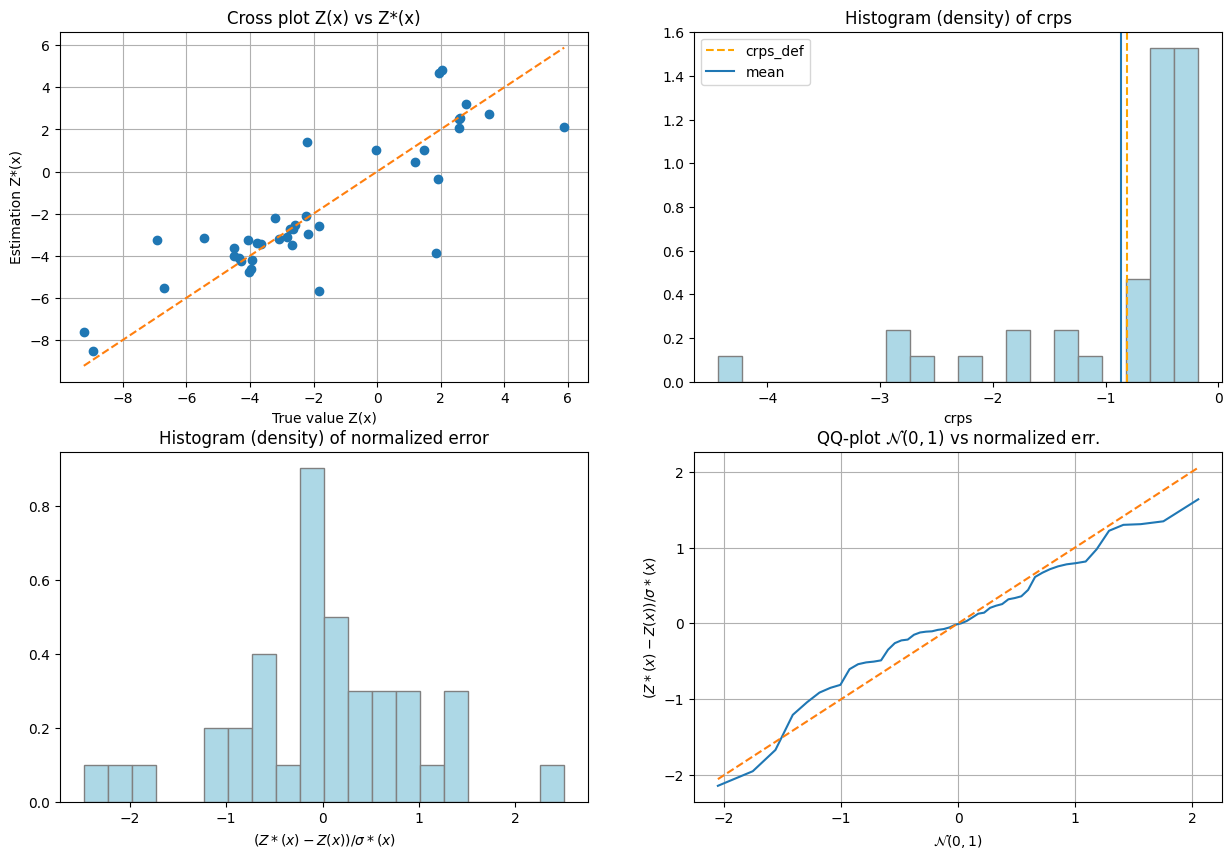

In [14]:
# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige,
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

----- CRPS (negative; the larger, the better) -----
   mean = -0.8607
   def. = -0.8052
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9955
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.6315
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = -0.0008858 (should be close to 0)
   std      = 0.9544 (should be close to 1)
   skewness = -0.2788 (should be close to 0)
   excess kurtosis = 0.9001 (should be close to 0)


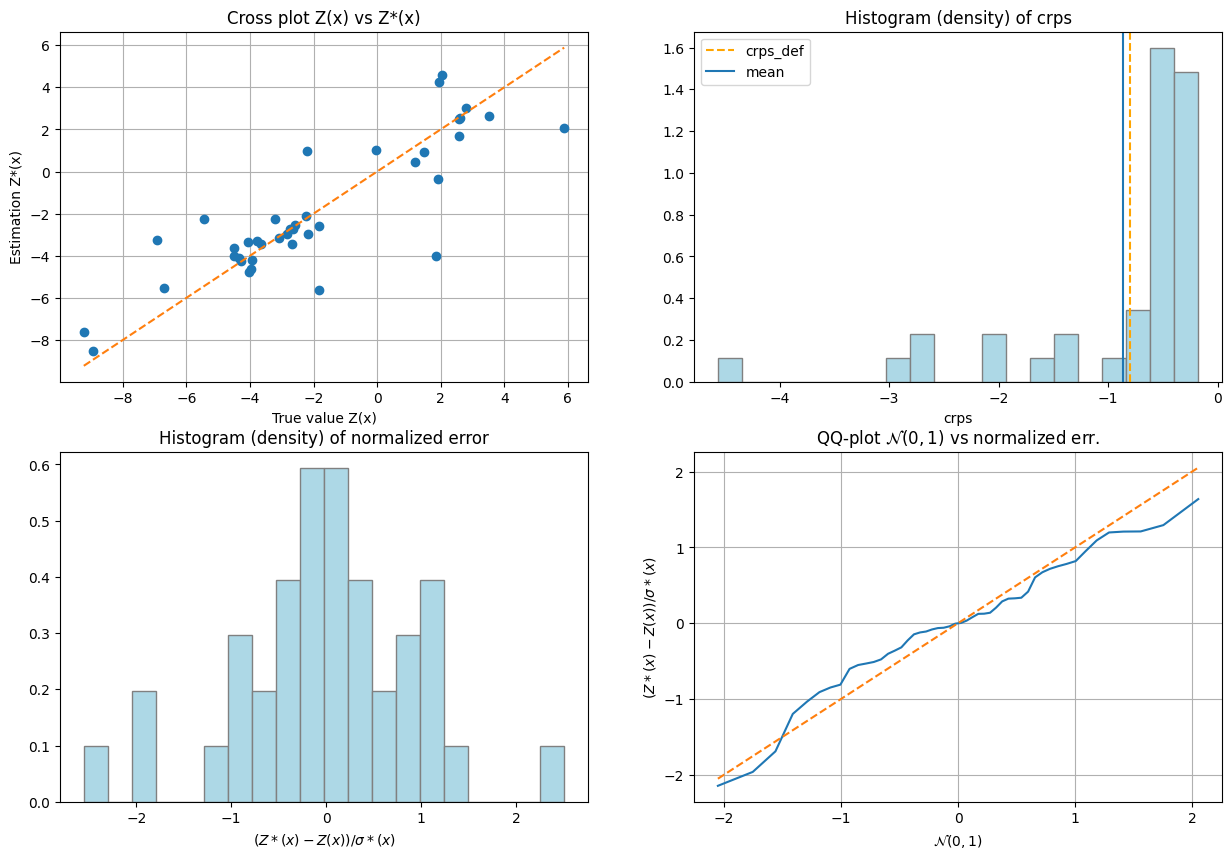

In [15]:
# Interpolation by ordinary kriging
cv_est2, cv_std2, crps2, crps_def2, pvalue2, success2 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, interpolator_kwargs={'method':'simple_kriging'},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

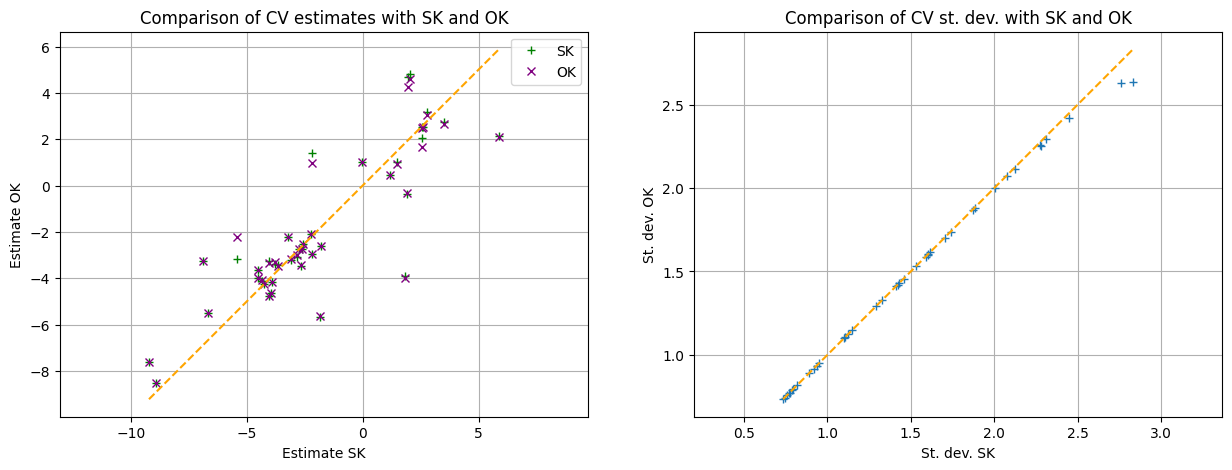

In [16]:
# Comparison of cross-validation with simple kriging and ordinary kriging
plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
# plt.plot(cv_est1, cv_est2, marker='+', ls='')
# plt.plot([np.min(cv_est1), np.max(cv_est1)], [np.min(cv_est1), np.max(cv_est1)], c='orange', ls='dashed')
# plt.axis('equal')
# plt.xlabel('Estimate SK')
# plt.ylabel('Estimate OK')
plt.plot(v, cv_est1, c='green', marker='+', ls='', label='SK')
plt.plot(v, cv_est2, c='purple', marker='x', ls='', label='OK')
plt.plot([np.min(v), np.max(v)], [np.min(v), np.max(v)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('Estimate SK')
plt.ylabel('Estimate OK')
plt.legend()
plt.grid()
plt.title('Comparison of CV estimates with SK and OK')

plt.subplot(1,2,2)
plt.plot(cv_std1, cv_std2, marker='+', ls='')
plt.plot([np.min(cv_std1), np.max(cv_std1)], [np.min(cv_std1), np.max(cv_std1)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('St. dev. SK')
plt.ylabel('St. dev. OK')
plt.title('Comparison of CV st. dev. with SK and OK')
plt.grid()
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued. 

## Covariance model fitted on data with error
When data error (standard deviation of a zero-mean Gaussian) distribution is considered,
a nugget effect of the (mean) of the error variance should be substracted from the covariance model used.

*Thus, to avoid negative nugget, we can impose a lower bound for the nugget contribution when fitting the model.*

In [17]:
# ... elementary contribution of index 3 is the nugget
cov_model_opt.elem[3]

('nugget', {'w': np.float64(0.26719882643054554)})

In [18]:
# Substract variance error from the nugget
try:
    cov_model_opt.add_w(-v_err_std**2, elem_ind=3)
except:
    print('Ensure minimal nugget of variance error in the fitted covariance model')

In [19]:
cov_model_opt.elem[3]

('nugget', {'w': np.float64(0.22719882643054554)})

## Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
The function `geone.covModel.krige(x, v, xu, cov_model, **kwargs)` return the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Type of kriging is determined by the keyword argument `method`:

- `method='simple_kriging'`: simple kriging is used, with the mean according to the keyword argument `mean` (mean of the data values is used if `mean=None`)
- `method='ordinary_kriging'` (default): ordinary kriging is used (the keyword argument `mean` must be `None` in this case)

Furthermore, the following parameters (keyword arguments) are available:

- `use_unique_neighborhood`: boolean
    - if `True`: kriging is done with a unique neighborhood (i.e. accounting for all data points)
    - if `False` (default): kriging is done by accounting for (a limited number of) data points within a search ellipsoid centered at the estimated point (see parameters `searchRadius`, `searchRadiusRelative` and `nneighborMax`)
- `searchRadius` : float or `None`; if specified (not `None`), radius of the search ellipsoid in any direction
- `searchRadiusRelative`: float, used only if `searchRadius=None`, then with $r_i$ is the range of the covariance model along the direction $i$, the radius of the search ellipsoid is set to `searchRadiusRelative` $\cdot$ $r_i$ in that direction
- `nneighborMax` : int, maximal number of data points taken into account for kriging 

For data in `d` dimension (here d=1):

- `x`: 2-dimensional array of shape `(n, d)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points
- `xu`: 2-dimensional array of shape `(m, d)` or 1-dimensional array of length `m`, location of points where the interpolation is done

In return:

- `vu`: 1-dimensional array of length `m`, kriging estimates at location `xu`
- `vu_std`: 1-dimensional array of length `m`, kriging standard deviation at location `xu`


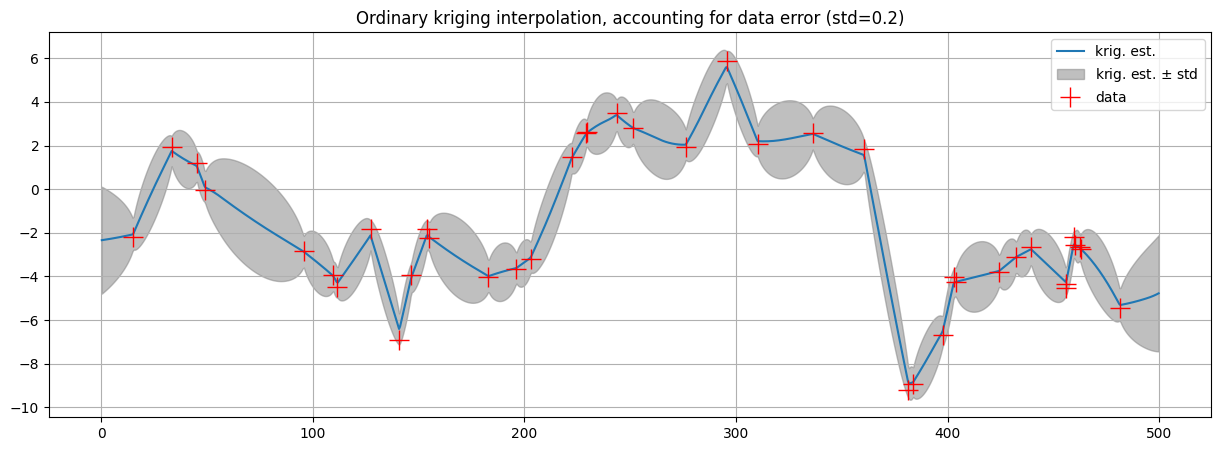

In [20]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*sx

# Simple kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, v_err_std=v_err_std, method='ordinary_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(15,5))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.title(f'Ordinary kriging interpolation, accounting for data error (std={v_err_std})')
plt.show()

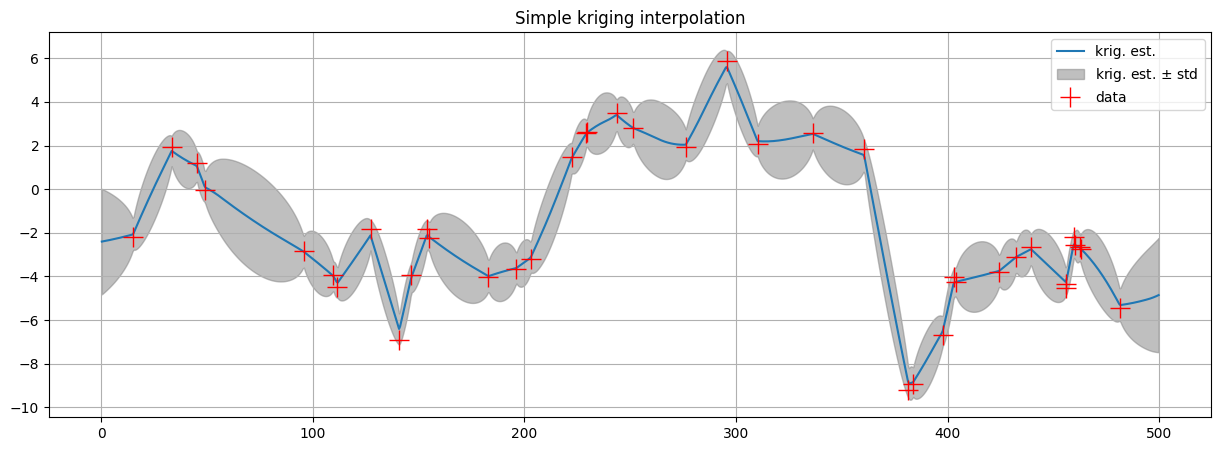

In [21]:
# Define points xu where to interpolate
# ... location of the 1D-grid used to build the data set (but it could be different)
xu = ox + (np.arange(nx)+0.5)*sx

# Ordinary kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, v_err_std=v_err_std, method='simple_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Plot
plt.figure(figsize=(15,5))
plt.plot(xu, vu, label='krig. est.')
plt.fill_between(xu, vu-vu_std, vu+vu_std, color='gray', alpha=0.5, label=r'krig. est. $\pm$ std')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.title('Simple kriging interpolation')
plt.show()

## Simulation based on simple or ordinary kriging: function `geone.covModel.sgs`
The function `geone.covModel.sgs(x, v, xu, cov_model, **kwargs)` performs sequential gaussian simulation (SGS) based on simple or ordinary kriging, it returns realizations at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Simulation uses a limited neighorhood, i.e. a limited number of data points and previously simulated points are taken into account to solve the kriging system for simulating the value at a point, which is drawn in a normal law of mean equal to the kriged value and variance equal to the kriging variance.

Number of realizations is set by the keyword argument `nreal`. The type of kriging is set by the keyword argument `method`, the maximal number of neighbors and the search ellipsoid by `searchRadius`, `searchRadiusRelative` and `nneighborMax`, as for the function `geone.covModel.krige` (see above); note that *unique neighborhood* is not possible for simulation.

For data in 1D:

- `x`: 2-dimensional array of shape `(n, 1)` or 1-dimensional array of length `n`, location of data points
- `v`: 1-dimensional array of length `n`, values at data points
- `xu`: 2-dimensional array of shape `(m, 1)` or 1-dimensional array of length `m`, location of points where the simulation is done

In return:

- `vu`: 2-dimensional array of shape `(nreal, m)`, each row is a realization of the simulated values at `xu`

### Launching multiple processes for multi-realizations of SGS
The function `geone.covModel.sgs_mp` launches multiple processes, allowing to generate multiple realizations in parallel.

The function `geone.covModel.sgs_mp` has the same parameters as the function `geone.covModel.sgs`, plus the parameter `nproc`, determining the number of parallel processes. This function will run `nproc` parallel processes (parallel calls of function `geone.covModel.sgs`). The ensemble of realizations (specified by `nreal`) is distributed in a balanced way over the process(es). For the parameter `nproc`, a negative number (or zero) (by default `nproc=-1`), `nproc = -n` $\leqslant$ `0`, can be specified to use the total number of cpu(s) of the system except `n`; `nproc` is finally at maximum equal to `nreal` but at least `1` by applying:
- if `nproc` $\geqslant$ `1`, then `nproc = max(min(nproc, nreal), 1)` is used
- if `nproc = -n` $\leqslant$ `0`, then `nproc = max(min(nmax-n, nreal), 1)` is used, where `nmax` is the total number of cpu(s) of the system (retrieved by `os.cpu_count()`) 


Elapsed time: 0.55 sec


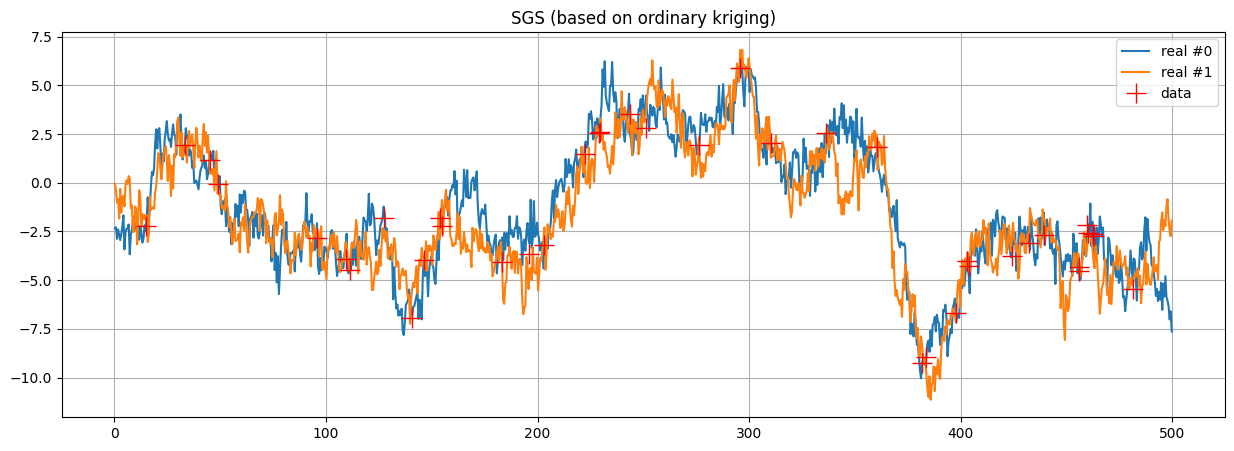

In [22]:
# Define points xu where to simulate
sim_xu = xu

# SGS based on simple kriging
nreal = 2
np.random.seed(321)
t1 = time.time()
sim_vu = gn.covModel.sgs(x, v, sim_xu, cov_model_opt, v_err_std=v_err_std, method='ordinary_kriging', nreal=nreal)  
# sim_vu:   2-dimensional array of shape (nreal, len(sim_xu)), each row is a realization 
#           (simulated values at locations sim_xu)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Plot
plt.figure(figsize=(15,5))
plt.plot(sim_xu, sim_vu[0], label='real #0')
plt.plot(sim_xu, sim_vu[1], label='real #1')
plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.title('SGS (based on ordinary kriging)')
plt.show()

## Kriging estimation and simulation in a grid
The functions above (`gn.covModel.krige` and `gn.covModel.sgs[_mp]`) should not be used for kriging and SGS in a regular grid. There are dedicated functions that should be used instead (much faster for large grid (in 2D or 3D)), in the module `geone.geosclassicinterface` (see notebooks `ex_geosclassic_*.ipynb`), and the module `geone.grf` (see notebooks `ex_grf_*.ipynb`).

A brief description is given here:
- `geone.geosclassicinterface.estimate`: estimation (kriging) in a grid
- `geone.geosclassicinterface.simulate`: simulation (SGS) in a grid
- `geone.grf.krige<d>D`: estimation (kriging) in a `<d>`-dimensional grid
- `geone.grf.grf<d>D`: simulation (SGS) in a `<d>`-dimensional grid

*Note: the functions of the module `geone.grf` are based on "Fast Fourier Transform" and allow for simple kriging only, and do not handle error on data or inequality data.*

### Wrapper

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments:

- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate`
- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate`
- `mode='estimation', algo='fft'`: wrapper for `geone.grf.krige<d>D`
- `mode='simulation', algo='fft'`: wrapper for `geone.grf.grf<d>D`

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned


## Examples

### Estimation using the function `geone.covModel.krige`

In [23]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, v_err_std=v_err_std, method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.0065 sec


### Estimation using the function `geone.grf.krige1D` 
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='fft'`.

In [24]:
t1 = time.time()
vu_grf, vu_std_grf = gn.multiGaussian.multiGaussianRun(
                        cov_model_opt, nx, sx, ox, 
                        x=x, v=v,
                        mode='estimation', algo='fft', output_mode='array')
# # Or
# vu_grf, vu_std_grf = gn.grf.krige1D(
#                         cov_model_opt, nx, sx, ox, 
#                         x=x, v=v)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krige1D: Computing circulant embedding...
krige1D: embedding dimension: 2048
krige1D: Computing FFT of circulant matrix...
krige1D: Computing covariance matrix (rAA) for conditioning locations...
krige1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige1D: Computing rBA * rAA^(-1)...
krige1D: computing kriging estimates...
krige1D: computing kriging standard deviation ...
Elapsed time: 0.041 sec


### Estimation using the function `geone.geosclassicinterface.estimate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='classic'`.

In [25]:
t1 = time.time()
vu_gci, vu_std_gci = gn.multiGaussian.multiGaussianRun(
                        cov_model_opt, nx, sx, ox, x=x, v=v,
                        mode='estimation', algo='classic', output_mode='array', 
                        v_err_std=v_err_std,
                        method='simple_kriging', use_unique_neighborhood=True,
                        nthreads=8)
# # Or
# estim_gci = gn.geosclassicinterface.estimate(
#                         cov_model_opt, nx, sx, ox, 
#                         x=x, v=v,
#                         v_err_std=v_err_std,
#                         method='simple_kriging', use_unique_neighborhood=True)
# vu_gci, vu_std_gci = estim_gci['image'].val[:,0,0,:]
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

estimate: Preprocessing data done: final number of data points : 40, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 0.027 sec


### Plot results of estimation

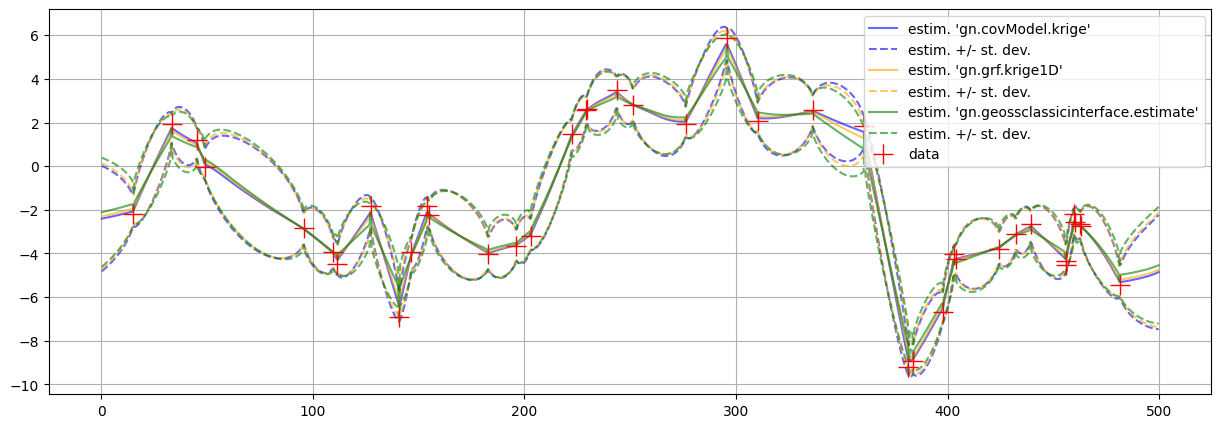

In [26]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(xu, vu, color='blue', ls='solid', alpha=.6, label="estim. 'gn.covModel.krige'")
plt.plot(xu, vu + vu_std, color='blue', ls='dashed', alpha=.6, label='estim. +/- st. dev.')
plt.plot(xu, vu - vu_std, color='blue', ls='dashed', alpha=.6)

plt.plot(xu, vu_grf, color='orange', ls='solid', alpha=.6, label="estim. 'gn.grf.krige1D'")
plt.plot(xu, vu_grf + vu_std_grf, color='orange', ls='dashed', alpha=.6, label='estim. +/- st. dev.')
plt.plot(xu, vu_grf - vu_std_grf, color='orange', ls='dashed', alpha=.6)

plt.plot(xu, vu_gci, color='green', ls='solid', alpha=.6, label="estim. 'gn.geossclassicinterface.estimate'")
plt.plot(xu, vu_gci + vu_std_gci, color='green', ls='dashed', alpha=.6, label='estim. +/- st. dev.')
plt.plot(xu, vu_gci - vu_std_gci, color='green', ls='dashed', alpha=.6)

plt.plot(x, v, 'r+', markersize=15, label='data')
plt.grid()
plt.legend()
plt.show()

In [27]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige1D'                   = {}".format(np.ptp(vu - vu_grf)))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate' = {}".format(np.ptp(vu - vu_gci)))
print("Peak-to-peak estimation 'gn.grf.krige1D    - gn.geosclassicinterface.estimate' = {}".format(np.ptp(vu_grf - vu_gci)))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige1D'                   = {}".format(np.ptp(vu_std - vu_std_grf)))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate' = {}".format(np.ptp(vu_std - vu_std_gci)))
print("Peak-to-peak st. dev.   'gn.grf.krige1D    - gn.geosclassicinterface.estimate' = {}".format(np.ptp(vu_std_grf - vu_std_gci)))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige1D'                   = 0.6202799930551004
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate' = 1.596589893876738
Peak-to-peak estimation 'gn.grf.krige1D    - gn.geosclassicinterface.estimate' = 0.9905537155280293
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige1D'                   = 0.11695451499708254
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate' = 0.2982567859129016
Peak-to-peak st. dev.   'gn.grf.krige1D    - gn.geosclassicinterface.estimate' = 0.25057269986451836


### Conditional simulation using the function `geone.covModel.sgs`

In [28]:
np.random.seed(293)

# SGS based on simple kriging
nreal = 200 # only!
t1 = time.time()
sim_vu = gn.covModel.sgs(x, v, xu, cov_model_opt, v_err_std=v_err_std, method='ordinary_kriging', nreal=nreal)  
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))


Elapsed time: 51 sec


### Conditional simulation using the function `geone.grf.grf1D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='fft'`.

In [29]:
np.random.seed(293)

t1 = time.time()
nreal = 1000
sim_grf = gn.multiGaussian.multiGaussianRun(
                        cov_model_opt, nx, sx, ox, 
                        x=x, v=v,
                        mode='simulation', algo='fft', output_mode='array',
                        nreal=nreal)
# # Or:
# sim_grf = gn.grf.grf1D(
#                         cov_model_opt, nx, sx, ox, 
#                         x=x, v=v, 
#                         nreal=nreal)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

grf1D: Preliminary computation...
grf1D: Computing circulant embedding...
grf1D: embedding dimension: 2048
grf1D: Computing FFT of circulant matrix...
grf1D: Treatment of conditioning data...
grf1D: Computing covariance matrix (rAA) for conditioning locations...
grf1D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 9.4 sec


### Conditional simulation using the function `geone.geosclassicinterface.simulate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='classic'`, and specifying the computational resources (`nproc` and `nthreads_per_proc`).

In [30]:
np.random.seed(293)

t1 = time.time()
nreal = 1000
sim_gci = gn.multiGaussian.multiGaussianRun(
                        cov_model_opt, nx, sx, ox, 
                        x=x, v=v,
                        mode='simulation', algo='classic', output_mode='array',
                        v_err_std=v_err_std, 
                        method='simple_kriging',
                        nreal=nreal,
                        nproc=2, nthreads_per_proc=4)
# # Or:
# sim_gci = gn.geosclassicinterface.simulate(
#                         cov_model_opt, nx, sx, ox, 
#                         x=x, v=v,
#                         v_err_std=v_err_std, 
#                         method='simple_kriging',
#                         nreal=nreal,
#                         nproc=2, nthreads_per_proc=4)
# sim_gci = sim_gci['image'].val[:,0,0,:]
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulate: Preprocessing data done: final number of data points : 40, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (1000 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed time: 1.5 sec


### Plot some realizations and compare to the reference simulation

In [31]:
sim_vu_mean = sim_vu.mean(axis=0)
sim_vu_std  = sim_vu.std(axis=0)

sim_grf_mean = sim_grf.mean(axis=0)
sim_grf_std  = sim_grf.std(axis=0)

sim_gci_mean = sim_gci.mean(axis=0)
sim_gci_std  = sim_gci.std(axis=0)

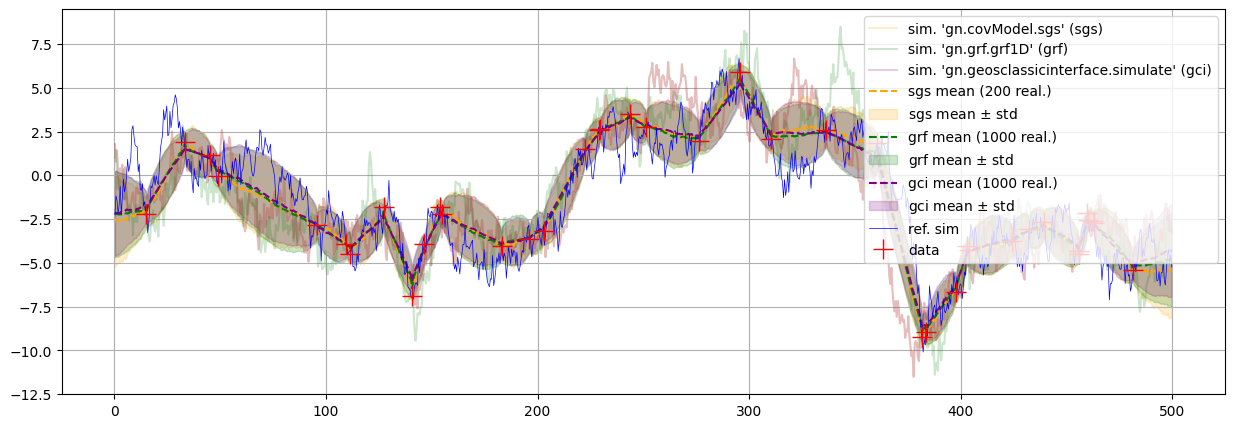

In [32]:
# Plot
plt.figure(figsize=(15,5))

for i in range(1):
    if i == 0:
        label = "sim. 'gn.covModel.sgs' (sgs)"
    else:
        label = None
    plt.plot(xu, sim_gci[i], color='orange', alpha=.2, label=label)

for i in range(1):
    if i == 0:
        label = "sim. 'gn.grf.grf1D' (grf)"
    else:
        label = None
    plt.plot(xu, sim_grf[i], color='green', alpha=.2, label=label)

for i in range(1):
    if i == 0:
        label = "sim. 'gn.geosclassicinterface.simulate' (gci)"
    else:
        label = None
    plt.plot(xu, sim_gci[i], color='purple', alpha=.2, label=label)

plt.plot(xu, sim_vu_mean, color='orange', ls='dashed', label=f'sgs mean ({200} real.)')
plt.fill_between(xu, sim_vu_mean-sim_vu_std, sim_vu_mean+sim_vu_std, color='orange', alpha=0.2, label=r'sgs mean $\pm$ std')

plt.plot(xu, sim_grf_mean, color='green', ls='dashed', label=f'grf mean ({nreal} real.)')
plt.fill_between(xu, sim_grf_mean-sim_grf_std, sim_grf_mean+sim_grf_std, color='green', alpha=0.2, label=r'grf mean $\pm$ std')

plt.plot(xu, sim_gci_mean, color='purple', ls='dashed', label=f'gci mean ({nreal} real.)')
plt.fill_between(xu, sim_gci_mean-sim_gci_std, sim_gci_mean+sim_gci_std, color='purple', alpha=0.2, label=r'gci mean $\pm$ std')

# plt.plot(xu, vu, color='lightblue', ls='dashed', label='krig. estim.')
# plt.fill_between(xu, vu-vu_std, vu+vu_std, color='blue', alpha=0.2, label=r'krig. estim. $\pm$ std')

plt.plot(xu, ref[0], color='blue', lw=.5, label='ref. sim')

plt.plot(x, v, 'r+', markersize=15, label='data')

plt.grid()
plt.legend(loc='upper right')
plt.show()